# TensorFlow Implementation of MLP

This is a walkthrough of a TensorFlow implementation of a Multi-Layered Perceptron (MLP), or also known as a Feed-Forward Neural Network. This is a re-implementation of an MLP written in python/numpy, and also serves as an introduction to the TensorFlow python API. The model has 2 fully-connected layers (one with 100 hidden units, one with 3 to match the number of output classes). It was tested on a "Task" dataset with 2 inputs, 3 classes, and 15,000 examples.

The model has ReLU activations, Dropout, and some L2 Regularisation.

In [1]:
import tensorflow as tf
import data_tools as dt

import os
import csv

import matplotlib.pyplot as plt
%matplotlib inline

## Load and Process the Task Dataset

Firstly use a data manager I wrote earlier to process the dataset.

In [2]:
filepath = 'data/task/task1.csv'
data_manager = dt.TaskData(filepath, (0.8,0.10,0.10))
data_manager.init_dataset()

Preparing Train/Valid/Test data from data/task/task1.csv
Split train has (4000, 4000, 4000) examples of each class
Split valid has (500, 500, 500) examples of each class
Split test has (500, 500, 500) examples of each class
Dataset prepared


True

In [3]:
train_x, train_y = data_manager.prepare_train()
valid_x, valid_y = data_manager.prepare_valid()

## Prepare Model

### Weights and Placeholders

TensorFlow works by first defining a computational graph. This defines points for feeding data, marked by `placeholders` and various operations. In the graph definition, we specify placeholders for the input variables, called `x` here, and also for the ground truth labels, called `y_` here.
For Dropout, a `keep_prob` placeholder has also been defined, allowing the probability of dropping weights to be set as an input to the graph.

The weights for two layers have also been defined, initialised with a normal distribution about 0 with a standard deviation of 0.1. This initialisation gives the initial network some original "motion" to take some steps and begin to optimise.

The "layers" defined here for Fully-Connected Layers (FC) as in a Multi-Layer Perceptron (MLP) are simple linear operations. `W1` is a matrix of weights, that maps 2 inputs to 100 hidden units (hence the `[2,100]` shape), while `b1` are biases for those 100 units. `W2` and `b1` similarly form an FC layer and operate from the 100 units of the previous layer to 3 outputs, the same as the number of output classes.

Variables in TensorFlow represent quantities, like weights, that are changed to optimise and reduce the loss of the model prediction.

In [4]:
# Input placeholders for feeding in the features, x, and ground truth labels, y_
x = tf.placeholder("float", shape=[None, 2])
y_ = tf.placeholder("float", shape=[None, 3])

# Dropout: probability of keeping a given weight where Dropout is applied
keep_prob = tf.placeholder("float")

# First Layer Weights
W1 = tf.Variable(tf.truncated_normal([2,100], stddev=0.1))
b1 = tf.Variable(tf.truncated_normal([100], stddev=0.1))

# Second Layer Weights
W2 = tf.Variable(tf.truncated_normal([100,3], stddev=0.1))
b2 = tf.Variable(tf.truncated_normal([3], stddev=0.1))

## FC Layer Operations and Non-Linearity

Next we can define some operations on the inputs and weights, simple linear FC operations. Our inputs, weights and outputs are low-rank tensors that flow through these operations, hence the name `TensorFlow`.

Here, `o1` is the output of the first layer. It has also had a Rectified Linear Unit activation applied to it, which introduces non-linearity and allows our network to approximate functions generally.
`o2` is the output of the second layer, which will go through a Softmax function rather than ReLU in this small network.

These operations are:

$$
\begin{align*}
O_1 &= \max(0, XW_1 + b_1)
\\
O_2 &= O_1W_2 + b_2
\end{align*}
$$

where the `O`s and `W`s are matrices, while the `X`s and `b`s are row vectors, or matrices of multiple examples, marked with subscripts that represent the layers.

### Dropout

Dropout is another form of regularisation that is popular with Neural Networks, and helps the network generalise beyond its training data. Without dropout, several hidden units may combine to produce one function together and always operate in this collaborative way. With dropout, some of the time these hidden units will be forced to operate independently, breaking away from this single-unit collaborative behaviour. This should help the network generalise, by stopping it from over fitting shapes specific to the training data, and instead learn something a bit more general about the data.

In [5]:
# Layer 1, FC Layer with ReLU activation
o1 = tf.nn.relu(tf.matmul(x,W1) + b1)
# Add Dropout to first layer
o1_dropout = tf.nn.dropout(o1, keep_prob)

# Layer 2
o2 = tf.matmul(o1_dropout,W2) + b2

## Softmax and Cross-Entropy Loss

### Softmax

Our final layer output goes through a softmax function, to convert the outputs into probabilties, called `y` here. The softmax function emphasises large values, and pushes down small values. The softmax function:

$${\rm Softmax}(Z)_i = \frac{e^{z_i} }{\sum_j^N e^{z_j} } = p_i \qquad \text{for } i=1,...,N$$

where $Z$ are the final layer outputs (represented by `o2` in code) and $N$ is the number of classes (3 here). 

### Cross-Entropy Loss

For classification, the Cross-Entropy loss is used. In this implementation, it considers the model output probability of the correct class (masked by `y_` which is one-hot encoded), and penalises the probability the further away it is from 1.0. Small log values would be largely negative, tending to $-\infty$, which when you take the negative of becomes a largely positive cost value. Large cost is undesirable and represents a poor prediction. The loss function is defined:

$$L = - Y \log (p)$$

where $L$ is the cross-entropy loss, $Y$ are the correct ground truth labels (`y_` in the code) that are non-zero only for the correct class, and $p$ are the output probabilities for each class (`y` in the code)).

The softmax and cross entropy can be conbined in TensorFlow with the `tf.nn.softmax_cross_entropy_with_logits()` function.

### Regularisation

For L2 Regularisation, the loss is penalised for having large network weights.

The variable `reg_lambda` (regularisation lambda) is a parameter that affects how much the weights penalise the loss.
The L2 Regularisation is defined as:

$$\delta {\rm loss} = \frac{1}{2} \lambda \sum_i (W_i^2)$$

Where this sum is carried out over every weight in the Neural Network. There are two sets of weights here, and the `tf.nn.l2_loss(weights)` performs the above calculation. This contribution to the loss from regularisation needs to be added to the loss function, with the `reg_lambda` factor.

In [6]:
# Predictions
y = tf.nn.softmax(o2)

# cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# Regularisation
reg_lambda = 1e-3
regulariser = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)

# Loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=o2, labels=y_)) + (reg_lambda * regulariser)

## Optimisation

In TensorFlow, optimisation is handled by an Optimiser object. It has been set to minimise the the loss from cross-entropy, and will update the network weights to do so. The variable `train_step` it has been assigned to can be fetched from the graph, which will calculate every dependent step up to that operation. So fetching `train_step` will perform both the forward and backward pass on the network.

In [7]:
learning_rate = 0.01
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

## Evaluation Operations

Here are some operations that perform some evaluation calculations. They compare the prediction with the labels, then calculate the average of correct predictions as the "accuracy."

In [8]:
# For Validation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## Training

### TensorFlow Session

To train, the operations on the graph need to be executed in a "session." Firstly, all the variables are initialised at once in an optimised way, and the session is started.

In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

### Logging

Import a handy litte logger I wrote earlier to just keep track of the Neural Network output.

In [10]:
from data_tools import Logger

# Set up a logger for the training data we want to record
quantities = ['Iteration', 'Train_Accuracy', 'Valid_Accuracy', 'Loss']
train_logs = Logger(*quantities)

### Training

Now we enter the training loop. In TensorFlow we can execute a calculation with `sess.run` where `sess` is a TensorFlow Session. For each iteration, we fetch `train_step` which performs the forward and backward pass including weight updates, and to do so we feed in data. Here the whole batch of training examples are fed into the placeholder `x`, and all the labels are fed into `y`.


In [11]:
# Dropout to apply during training
train_keep_prob = 0.7

for i in range(3001):
    feed_dict = {x: train_x, y_: train_y, keep_prob: train_keep_prob}
    train_accuracy, avg_loss, _ = sess.run([accuracy, loss, train_step], feed_dict=feed_dict)
    if i % 100 == 0:
        valid_accuracy = sess.run(accuracy, feed_dict={x: valid_x, y_: valid_y, keep_prob: 1.0})
        
        train_logs.log(Iteration=i, Train_Accuracy=train_accuracy, Valid_Accuracy=valid_accuracy, Loss=avg_loss)
        
        print('Iteration {:10}: loss {:6.3f} train accuracy {:7.3f} valid accuracy {:7.3f}'.format(
               i, avg_loss, train_accuracy, valid_accuracy))

Iteration          0: loss  1.072 train accuracy   0.440 valid accuracy   0.565
Iteration        100: loss  0.756 train accuracy   0.680 valid accuracy   0.690
Iteration        200: loss  0.653 train accuracy   0.767 valid accuracy   0.803
Iteration        300: loss  0.577 train accuracy   0.809 valid accuracy   0.839
Iteration        400: loss  0.525 train accuracy   0.831 valid accuracy   0.855
Iteration        500: loss  0.480 train accuracy   0.849 valid accuracy   0.869
Iteration        600: loss  0.444 train accuracy   0.864 valid accuracy   0.877
Iteration        700: loss  0.415 train accuracy   0.872 valid accuracy   0.885
Iteration        800: loss  0.394 train accuracy   0.877 valid accuracy   0.893
Iteration        900: loss  0.374 train accuracy   0.887 valid accuracy   0.901
Iteration       1000: loss  0.356 train accuracy   0.890 valid accuracy   0.907
Iteration       1100: loss  0.340 train accuracy   0.897 valid accuracy   0.911
Iteration       1200: loss  0.327 train 

In [12]:
train_logs.printlog()
experiment = 'notebook_tf_task_training'
train_logs.write_csv(os.path.join('experiment/',experiment+'.csv'))

Iteration           Train_Accuracy      Valid_Accuracy      Loss                
0                   0.440167            0.565333            1.071974            
100                 0.680333            0.690000            0.756237            
200                 0.766583            0.802667            0.652530            
300                 0.808750            0.838667            0.577155            
400                 0.830750            0.855333            0.524733            
500                 0.848833            0.869333            0.480030            
600                 0.864417            0.876667            0.444221            
700                 0.872417            0.885333            0.414758            
800                 0.877167            0.893333            0.393510            
900                 0.887000            0.900667            0.374112            
1000                0.890083            0.906667            0.356380            
1100                0.897167

## Plot the Output

Read in the experiment CSV and make some output plots.

In [13]:
def load_logs(logfile, discard_header=False):
    iteration, train_accuracy, valid_accuracy, loss = [], [], [], []
    with open(logfile) as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            if discard_header:
                discard_header = False
                continue
            r_it, r_train_acc, r_valid_acc, r_loss = row
            iteration.append(int(r_it))
            train_accuracy.append(float(r_train_acc))
            valid_accuracy.append(float(r_valid_acc))
            loss.append(float(r_loss))
    return iteration, train_accuracy, valid_accuracy, loss

logfile = 'experiment/' + experiment + '.csv'
it_fc100, tr_acc_fc100, va_acc_fc100, loss_fc100 = load_logs(logfile, discard_header=True)
# iteration, training accuracy, validation accuracy, loss for FC100-ReLU-Dropout-FC3 configuration

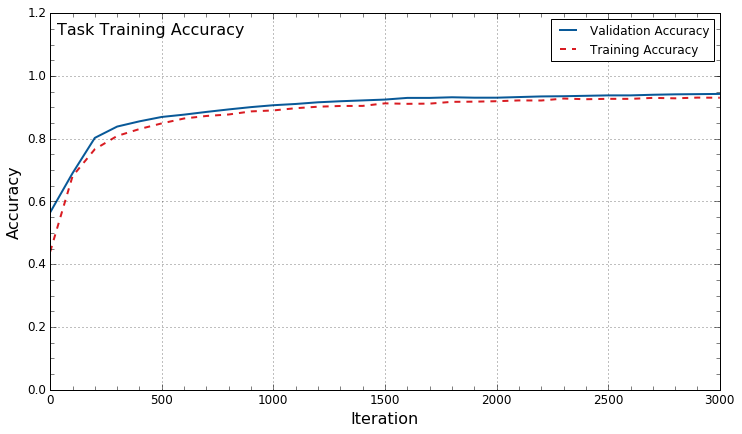

In [14]:
# Colours
col_pink   = '#E13375'
col_blue   = '#095998'
col_orange = '#F17B18'
col_green  = '#29C78D'

col_red    = '#d91c22'
col_cyan   = '#1cd9cc'
col_green  = '#81d91c'

# Set figure size
fig, ax = plt.subplots(figsize=(12,6.75))

# Plotting multiple lines
ax.plot(it_fc100, va_acc_fc100, linewidth=2, color=col_blue, label='Validation Accuracy')
ax.plot(it_fc100, tr_acc_fc100, '--', linewidth=2, color=col_red, label='Training Accuracy')

# Plot title
ax.set_title('Task Training Accuracy', y=0.93, x=0.15, fontsize=16)

# Axes labels, fontsize (offset by adding y=0.0 etc to arguments)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)

# Ticks
ax.minorticks_on()
ax.tick_params(axis='both', which='major', right='on', top='on', direction='in', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', right='on', top='on', direction='in', labelsize=12, length=4)

# Set range limit on axes
ax.set_ylim([0,1.2])
ax.set_xlim([0,3000])

# To set a grid
ax.grid(True)

# Legend, generated from plot details and labels
ax.legend(loc=1, prop={'size': 12})

plt.show()
# plt.savefig('./experiment/' + the_date + '-' + plotname1 + '.png', bbox_inches='tight')

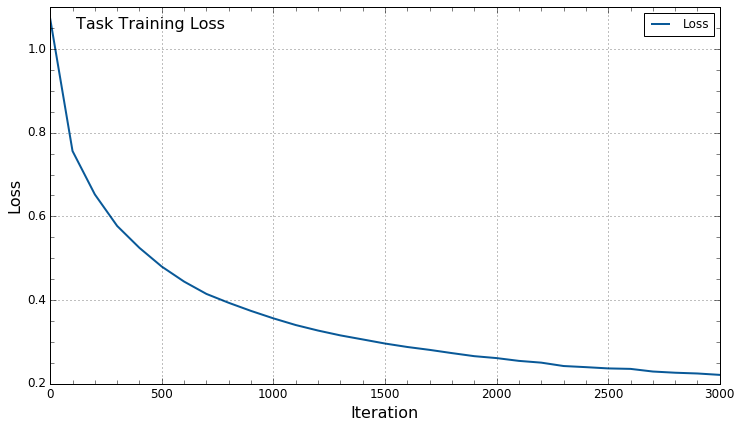

In [15]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,6.75))

ax.plot(it_fc100, loss_fc100, linewidth=2, color=col_blue, label='Loss')

# Plot title
ax.set_title('Task Training Loss', y=0.93, x=0.15, fontsize=16)

# Axes labels, fontsize (offset by adding y=0.0 etc to arguments)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)

# Ticks
ax.minorticks_on()
ax.tick_params(axis='both', which='major', right='on', top='on', direction='in', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', right='on', top='on', direction='in', labelsize=12, length=4)

# Set range limit on axes
# ax.set_ylim([0,1.2])
ax.set_xlim([0,3000])

# To set a grid
ax.grid(True)

# Legend, generated from plot details and labels
ax.legend(loc=1, prop={'size': 12})

plt.show()
# plt.savefig('./experiment/' + the_date + '-' + plotname2 + '.png', bbox_inches='tight')